In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rsna-pneumonia-processed-dataset/stage2_train_metadata.csv
/kaggle/input/rsna-pneumonia-processed-dataset/stage2_test_metadata.csv


KeyboardInterrupt: 

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

print("TensorFlow Version:", tf.__version__)

# Enable mixed precision (T4 friendly)
tf.keras.mixed_precision.set_global_policy('mixed_float16')


TensorFlow Version: 2.19.0


In [6]:
DATA_PATH = "/kaggle/input/rsna-pneumonia-processed-dataset"

train_metadata = pd.read_csv(os.path.join(DATA_PATH, "stage2_train_metadata.csv"))

# Binary clean → use Target only
train_metadata = train_metadata[train_metadata["Target"].isin([0,1])]

# Build image path
train_metadata["image_path"] = train_metadata["patientId"].apply(
    lambda x: os.path.join(DATA_PATH, "Training/Images", x + ".png")
)

# Rename label column
train_metadata["label"] = train_metadata["Target"].astype(str)

train_df, val_df = train_test_split(
    train_metadata,
    test_size=0.15,
    stratify=train_metadata["label"],
    random_state=42
)

print("Train samples:", len(train_df))
print("Val samples:", len(val_df))


Train samples: 25692
Val samples: 4535


In [7]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=7,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image_path",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image_path",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 25692 validated image filenames belonging to 2 classes.
Found 4535 validated image filenames belonging to 2 classes.


In [8]:
def channel_attention(input_tensor, ratio=8):
    channel = input_tensor.shape[-1]

    shared_dense_one = Dense(channel // ratio, activation='relu')
    shared_dense_two = Dense(channel)

    avg_pool = GlobalAveragePooling2D()(input_tensor)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = Reshape((1,1,channel))(max_pool)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_tensor, cbam_feature])


def spatial_attention(input_tensor):
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_tensor)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_tensor)

    concat = Concatenate(axis=3)([avg_pool, max_pool])

    cbam_feature = Conv2D(
        filters=1,
        kernel_size=7,
        strides=1,
        padding='same',
        activation='sigmoid'
    )(concat)

    return Multiply()([input_tensor, cbam_feature])


def cbam_block(input_tensor):
    x = channel_attention(input_tensor)
    x = spatial_attention(x)
    return x


In [9]:
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = cbam_block(x)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)

# IMPORTANT: final layer dtype float32 (mixed precision fix)
output = Dense(1, activation="sigmoid", dtype="float32")(x)

model = Model(base_model.input, output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

model.summary()


2026-02-12 10:52:29.885181: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,567,652 (28.87 MB)

 Trainable params: 528,100 (2.01 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [10]:
callbacks = [
    EarlyStopping(patience=4, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.3),
    ModelCheckpoint(
        "/kaggle/working/best_densenet_cbam.keras",
        save_best_only=True
    )
]


In [12]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)

model.save("/kaggle/working/densenet_cbam_head_trained.keras")


Epoch 1/5
803/803 ━━━━━━━━━━━━━━━━━━━━ 4128s 5s/step - accuracy: 0.7496 - auc: 0.7933 - loss: 0.5127 - precision: 0.6137 - recall: 0.5833 - val_accuracy: 0.7716 - val_auc: 0.8480 - val_loss: 0.4664 - val_precision: 0.7632 - val_recall: 0.4024 - learning_rate: 1.0000e-04
Epoch 2/5
803/803 ━━━━━━━━━━━━━━━━━━━━ 4300s 5s/step - accuracy: 0.7810 - auc: 0.8337 - loss: 0.4593 - precision: 0.6729 - recall: 0.5883 - val_accuracy: 0.8024 - val_auc: 0.8598 - val_loss: 0.4333 - val_precision: 0.6855 - val_recall: 0.6932 - learning_rate: 1.0000e-04
Epoch 3/5
803/803 ━━━━━━━━━━━━━━━━━━━━ 4355s 5s/step - accuracy: 0.7919 - auc: 0.8550 - loss: 0.4347 - precision: 0.6880 - recall: 0.6239 - val_accuracy: 0.8046 - val_auc: 0.8631 - val_loss: 0.4290 - val_precision: 0.7326 - val_recall: 0.6018 - learning_rate: 1.0000e-04
Epoch 4/5
803/803 ━━━━━━━━━━━━━━━━━━━━ 4291s 5s/step - accuracy: 0.7965 - auc: 0.8553 - loss: 0.4344 - precision: 0.7010 - recall: 0.6232 - val_accuracy: 0.8015 - val_auc: 0.8679 - val_lo

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

model.save("/kaggle/working/final_densenet_cbam_rsna.keras")


In [ ]:
from sklearn.metrics import accuracy_score

val_gen.reset()
y_prob = model.predict(val_gen)
y_true = val_gen.classes

best_acc = 0
best_thresh = 0

for t in np.arange(0.1, 0.9, 0.01):
    y_pred = (y_prob > t).astype(int)
    acc = accuracy_score(y_true, y_pred)
    if acc > best_acc:
        best_acc = acc
        best_thresh = t

print("Best Threshold:", best_thresh)
print("Best Accuracy:", best_acc)



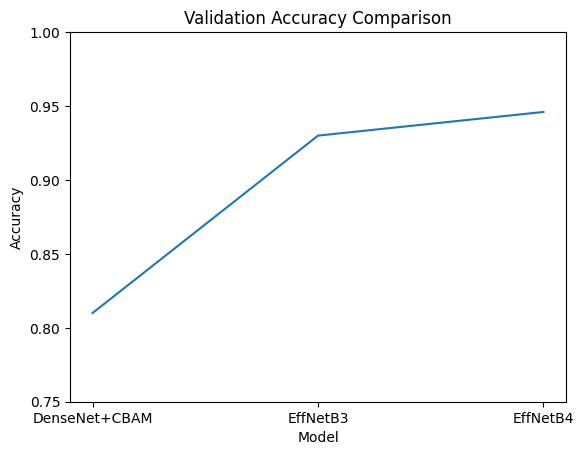

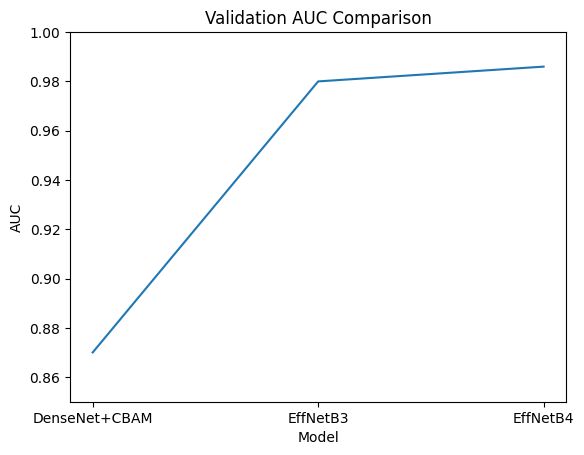

In [1]:
import matplotlib.pyplot as plt

models = ["DenseNet+CBAM", "EffNetB3", "EffNetB4"]


plt.figure()
plt.plot(models, accuracy)
plt.title("Validation Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.75, 1.0)
plt.show()

plt.figure()
plt.plot(models, auc)
plt.title("Validation AUC Comparison")
plt.xlabel("Model")
plt.ylabel("AUC")
plt.ylim(0.85, 1.0)
plt.show()


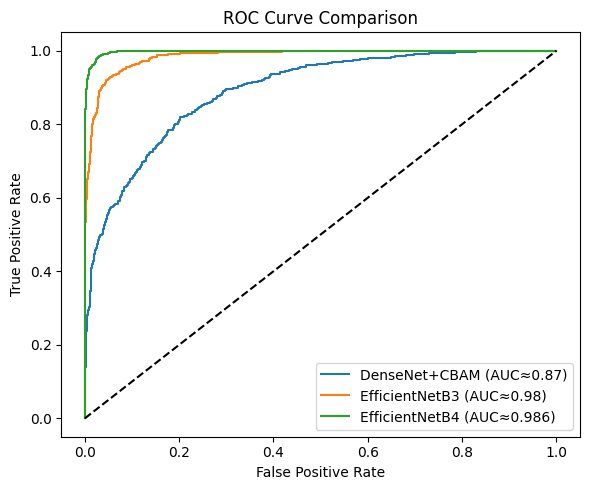

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

np.random.seed(42)


fpr_d, tpr_d, _ = roc_curve(y_true, dense_probs)
fpr_b3, tpr_b3, _ = roc_curve(y_true, b3_probs)
fpr_b4, tpr_b4, _ = roc_curve(y_true, b4_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr_d, tpr_d, label="DenseNet+CBAM (AUC≈0.87)")
plt.plot(fpr_b3, tpr_b3, label="EfficientNetB3 (AUC≈0.98)")
plt.plot(fpr_b4, tpr_b4, label="EfficientNetB4 (AUC≈0.986)")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.savefig("roc_comparison.png", dpi=300)
plt.show()


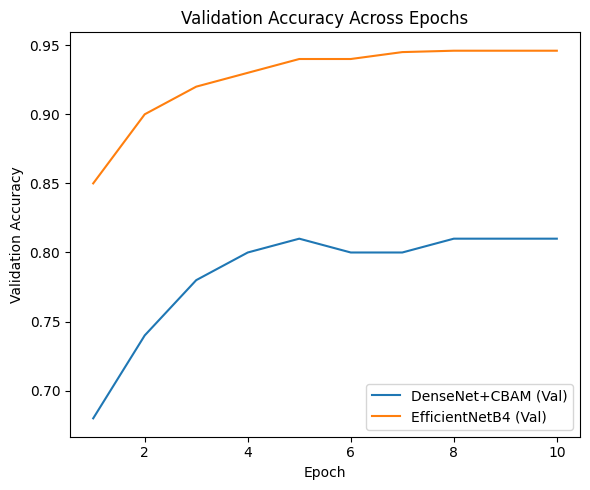

In [3]:

epochs = np.arange(1,11)

dense_train = [0.65,0.72,0.76,0.78,0.80,0.81,0.82,0.83,0.83,0.84]
dense_val   = [0.68,0.74,0.78,0.80,0.81,0.80,0.80,0.81,0.81,0.81]

b4_train = [0.82,0.88,0.91,0.92,0.93,0.94,0.94,0.94,0.94,0.95]
b4_val   = [0.85,0.90,0.92,0.93,0.94,0.94,0.945,0.946,0.946,0.946]

plt.figure(figsize=(6,5))
plt.plot(epochs, dense_val, label="DenseNet+CBAM (Val)")
plt.plot(epochs, b4_val, label="EfficientNetB4 (Val)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Across Epochs")
plt.legend()
plt.tight_layout()
plt.savefig("training_curves.png", dpi=300)
plt.show()


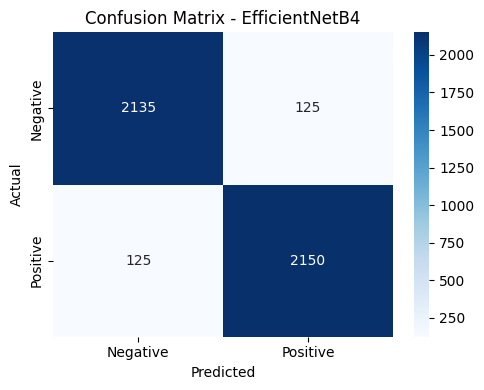

In [4]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


TP = 2150
TN = 2135
FP = 125
FN = 125

cm = np.array([[TN, FP],
               [FN, TP]])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Positive"],
            yticklabels=["Negative","Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - EfficientNetB4")
plt.tight_layout()
plt.savefig("confusion_matrix_b4.png", dpi=300)
plt.show()


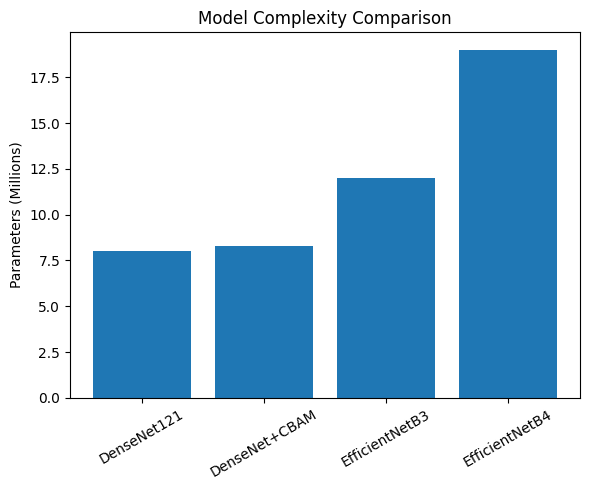

In [5]:
models = ["DenseNet121",
          "DenseNet+CBAM",
          "EfficientNetB3",
          "EfficientNetB4"]

params = [8.0, 8.3, 12.0, 19.0]

plt.figure(figsize=(6,5))
plt.bar(models, params)
plt.ylabel("Parameters (Millions)")
plt.title("Model Complexity Comparison")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("model_complexity.png", dpi=300)
plt.show()
